<a href="https://colab.research.google.com/github/alexeiplatzer/unitree-go2-mjx-rl/blob/main/notebooks/Preconfigured.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Univeral Notebook for Quadruped RL Training in MJX**
This notebook uses the `quadruped-mjx-rl` python package from the `unitree-go2-mjx-rl` repository to train locomotion policies for quadrupeds using reinforcement learning in the Mujoco XLA (MJX) simulation environment.

# Hardware Setup
This part sets up the `quadruped-mjx-rl` package on the machine.

In [1]:
#@title run this cell once each time on a new machine
#@markdown #### Setup configuration

#@markdown Choose your hardware option:
hardware = "Colab" #@param ["local","Colab","Kaggle"]

#@markdown Choose whether you want to build the madrona rendering setup for training
#@markdown with vision:
build_madrona_backend = False #@param {"type":"boolean"}

#@markdown Choose if you want to pull changes to the package repository during the runtime.
#@markdown (Requires a restart after executing this cell!)
editable_mode = True #@param {"type":"boolean"}

if build_madrona_backend:
    # Install madrona MJX
    import time
    print("Intalling Madrona MJX...")
    start_time = time.perf_counter()

    print("Setting up environment... (Step 1/3)")

    if hardware=="Kaggle":
        # Install the 12.4 cuda toolkit
        !wget -qO cuda-keyring.deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.1-1_all.deb
        !sudo dpkg -i ./cuda-keyring.deb
        !sudo apt-get update -y -qq
        !sudo apt-get install -y -qq cuda-toolkit-12-4
        %CUDA_HOME=/usr/local/cuda-12.4
        %CUDAToolkit_ROOT=/usr/local/cuda-12.4
        %XLA_FLAGS="--xla_gpu_cuda_data_dir=/usr/local/cuda-12.4"
        %PATH="/usr/local/cuda-12.4/bin:$PATH"
        %LD_LIBRARY_PATH="/usr/local/cuda-12.4/lib64:${LD_LIBRARY_PATH}"

    !pip install jax["cuda12"]==0.5.1

    !sudo apt install libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev

    !mkdir modules
    !git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx
    !git -C modules/madrona_mjx submodule update --init --recursive
    !mkdir modules/madrona_mjx/build

    print("Building the Madrona backend ... (Step 2/3)")
    !cmake -S modules/madrona_mjx -B modules/madrona_mjx/build -DLOAD_VULKAN=OFF
    !cmake --build modules/madrona_mjx/build -j

    print ("Installing Madrona MJX ... (Step 3/3)")
    !pip install modules/madrona_mjx

    minutes, seconds = divmod((time.perf_counter() - start_time), 60)
    print(f"Finished installing Madrona MJX in {minutes} m {seconds:.2f} s")

# Clones and installs our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
if editable_mode:
    !pip install -e unitree-go2-mjx-rl
else:
    !pip install unitree-go2-mjx-rl

Cloning into 'unitree-go2-mjx-rl'...
remote: Enumerating objects: 4490, done.
remote: Counting objects: 100% (1045/1045), done.
remote: Compressing objects: 100% (577/577), done.
remote: Total 4490 (delta 755), reused 683 (delta 422), pack-reused 3445 (from 2)
Receiving objects: 100% (4490/4490), 25.40 MiB | 7.85 MiB/s, done.
Resolving deltas: 100% (2927/2927), done.
Obtaining file:///content/unitree-go2-mjx-rl
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

### Now restart the session and continue.
### You can skip setup next time while you are on the same machine.

# Refresh package after pushed to the repo. Important in development

In [ ]:

repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

# Visualize environment before training

In [ ]:
# @title Expand

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, force=True)
logging.info("Logging switched on.")

#@markdown Choose whether you want to use the madrona backend for parallelized vision rendering
use_madrona_backend = False #@param {"type":"boolean"}

if use_madrona_backend:
    from pathlib import Path
    # On your second reading, load the compiled rendering backend to save time!
    cache_path = Path("modules/madrona_mjx/build/cache")
    if cache_path.exists():
        os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "modules/madrona_mjx/build/cache"
        logging.info("Madrona cache located and will be used.")
    # Ensure that Madrona gets the chance to pre-allocate memory before Jax
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Check if there is a GPU on the machine
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
import os
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
logging.info('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
    logging.info('Checking that the installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

logging.info('Mujoco installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare directories
from etils.epath import Path
repo_path = Path("unitree-go2-mjx-rl")
experiments_dir = Path("experiments")
trained_policy_dir = experiments_dir / "trained_policies"
!mkdir -p {trained_policy_dir}
configs_dir = experiments_dir / "configs"
!mkdir -p {configs_dir}
rollout_configs_dir = configs_dir / "rollout_configs"
!mkdir -p {rollout_configs_dir}
animations_dir = experiments_dir / "rendered_rollouts"
!mkdir -p {animations_dir}

#@markdown ---
# TODO render using mujoco's config and madrona

# Run training, policy visualisation, and save results
This visualisation can be run independently from the training section, including after restarts and crashes. As long as all the created files remain in the session's disk memory.

INFO:root:Logging switched on.
INFO:root:Setting environment variable to use GPU rendering:
INFO:root:Checking that the installation succeeded:
INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
INFO:root:Mujoco installation successful.


env: MUJOCO_GL=egl


INFO:root:Initializing the environment...
INFO:2025-12-17 10:44:04,427:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-12-17 10:44:04,515:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:Everything configured. Starting training loop.
INFO:root:Device count: 1, process count: 1 (

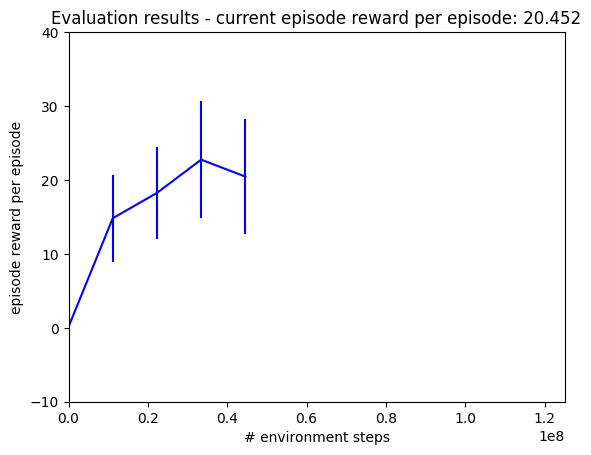

INFO:root:Setup took 35.55918216705322
INFO:root:current_step: 0
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root: eval/episode_reward: 0.12653511762619019
INFO:root: eval/episode_reward_std: 1.3856163024902344
INFO:root:starting iteration 0 169.46442103385925
INFO:root:training_metrics: {'training/sps': np.float64(46326.05173586598), 'training/walltime': 240.4936225414276, 'training/entropy_loss': Array(-0.047, dtype=float32), 'training/policy_loss': Array(-0.027, dtype=float32), 'training/total_loss': Array(-0.01, dtype=float32), 'training/v_loss': Array(0.064, dtype=float32)}
INFO:root:current_step: 11141120
INFO:root: eval/episode_reward: 14.821004867553711
INFO:root: eval/episode_reward_std: 5.899084091186523
INFO:root:starting iteration 1 514.60480260849
INFO:root:training_metrics: {'training/sps': np.float64(60845.14177815955), 'training/walltime': 423.599778175354, 'training/entropy_loss': Array(0.012, dtype=float3

In [ ]:
#@title Expand

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, force=True)
logging.info("Logging switched on.")

#@markdown Choose whether you want to use the madrona backend for parallelized vision rendering
use_madrona_backend = False #@param {"type":"boolean"}

if use_madrona_backend:
    from pathlib import Path
    # On your second reading, load the compiled rendering backend to save time!
    cache_path = Path("modules/madrona_mjx/build/cache")
    if cache_path.exists():
        os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "modules/madrona_mjx/build/cache"
        logging.info("Madrona cache located and will be used.")
    # Ensure that Madrona gets the chance to pre-allocate memory before Jax
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Check if there is a GPU on the machine
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
import os
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
logging.info('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
    logging.info('Checking that the installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

logging.info('Mujoco installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare directories
from pathlib import Path
repo_path = Path("unitree-go2-mjx-rl")
configs_dir = repo_path / "configs"
experiments_dir = Path("experiments")
experiments_dir.mkdir(parents=True, exist_ok=True)

# Prepare experiment results directory
existing_numbers = []
for experiment_path in experiments_dir.glob("experiment_*"):
    experiment_index = experiment_path.name.split("_")[1]
    if experiment_index.isdigit():
        existing_numbers.append(int(experiment_index))
next_number = max(existing_numbers) + 1 if existing_numbers else 0
experiment_dir = experiments_dir / f"experiment_{next_number}"
experiment_dir.mkdir()

training_plots_dir = experiment_dir / "training_plots"
training_plots_dir.mkdir()

#@markdown ---
import functools
from quadruped_mjx_rl.configs import prepare_all_configs
from quadruped_mjx_rl.terrain_gen import make_terrain
from quadruped_mjx_rl.environments.vision.robotic_vision import get_renderer
from quadruped_mjx_rl.environments import get_env_factory
from quadruped_mjx_rl.training import train, TrainingWithVisionConfig
from quadruped_mjx_rl.models.io import save_params

#@markdown Choose with which config file to train
config_file_name = "joystick_basic_ppo.yaml" #@param {"type":"string"}
robot_name = "unitree_go2" #@param ["unitree_go2", "google_barkour_vb"]
robot_config, terrain_config, env_config, model_config, training_config = prepare_all_configs(
    configs_dir / config_file_name, configs_dir / "robot_configs" / f"{robot_name}.yaml"
)

# Prepare environment model
init_scene_path = repo_path / "resources" / robot_name / terrain_config.base_scene_file
env_model = make_terrain(init_scene_path, terrain_config)

# Prepare the environment factory
vision = isinstance(training_config, TrainingWithVisionConfig)
renderer_maker = (
    functools.partial(
        get_renderer, vision_config=env_config.vision_env_config.vision_config, debug=debug
    )
    if vision
    else None
)
env_factory = get_env_factory(
    robot_config=robot_config,
    environment_config=env_config,
    env_model=env_model,
    customize_model=True,
    use_vision=vision,
    renderer_maker=renderer_maker,
)

logging.info("Initializing the environment...")
training_env = env_factory()
evaluation_env = env_factory() if not vision else None

logging.info("Everything configured. Starting training loop.")
trained_params = train(
    training_config=training_config,
    model_config=model_config,
    training_env=training_env,
    evaluation_env=evaluation_env,
    randomization_config=terrain_config.randomization_config,
    show_outputs=True,
    run_in_cell=True,
    save_plots_path=training_plots_dir,
)
save_params(params=trained_params, path=experiment_dir / "trained_policy")
logging.info("Training complete. Params saved.")

#@markdown ---
#@markdown Configure a rollout for rendering
# TODO: implement a policy rollout rendering
# TODO: implement results saving